In [1]:
import pandas as pd
import numpy as np
#import tiingo
import requests


In [2]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
cal = calendar()

holidays = cal.holidays(start='2000-01-01',
                        end='2030-12-30')

holiday_df = pd.DataFrame(data=holidays,
                          columns = ['date']).assign(holiday='USFederalHoliday')

In [3]:
### First we will get the 15min time intervals and calculate the 15min Moving averages (10 perido, 20 period, 50 period)
### From the same data we will also calculate the 1d Moving averages (10 period, 20 period, 50 period) and
### Append the indicators to the dataframe 
### Each iteration will run for a single ticker


### The data extracts work in 0GMT => Exchange opens at 14:30 and closes at 21:00
### Convert this to Sofia/New-York time if needed


In [4]:
# 15min to # 1h 
headers = {
    'Content-Type': 'application/json'
}
requestResponse = requests.get("https://api.tiingo.com/iex/DIS/prices?startDate=2015-01-02&endDate=2022-12-31&resampleFreq=1hour&columns=open,high,low,close,volume&token=0ed744c7db5ef348139953912e2f3cee79f4608b", headers=headers)
#print(requestResponse.json())

In [5]:
df_stock = pd.DataFrame(requestResponse.json()) 
df_stock

,date,open,high,low,close,volume
0,2017-06-12T17:00:00.000Z,106.715,107.180,106.715,106.795,15708.0
1,2017-06-12T18:00:00.000Z,106.795,106.910,106.695,106.745,8698.0
2,2017-06-12T19:00:00.000Z,106.780,107.080,106.770,107.050,17018.0
3,2017-06-12T20:00:00.000Z,107.050,107.050,107.050,107.050,0.0
4,2017-06-13T14:00:00.000Z,107.050,107.190,106.750,107.160,0.0
...,...,...,...,...,...,...
9995,2022-12-01T17:00:00.000Z,98.235,98.270,97.600,97.900,18836.0
9996,2022-12-01T18:00:00.000Z,97.930,98.195,97.590,97.940,21658.0
9997,2022-12-01T19:00:00.000Z,97.925,98.660,97.770,98.580,40668.0
9998,2022-12-01T20:00:00.000Z,98.580,98.830,98.300,98.680,65226.0


In [6]:
## This gets financial data
#requestResponse = requests.get("https://api.tiingo.com/tiingo/fundamentals/msft/statements?token=0ed744c7db5ef348139953912e2f3cee79f4608b", headers=headers)
#print(requestResponse.json)

In [7]:
requestResponse

<Response [200]>

In [8]:
df_stock = pd.DataFrame(requestResponse.json()) 

In [9]:
df_stock

,date,open,high,low,close,volume
0,2017-06-12T17:00:00.000Z,106.715,107.180,106.715,106.795,15708.0
1,2017-06-12T18:00:00.000Z,106.795,106.910,106.695,106.745,8698.0
2,2017-06-12T19:00:00.000Z,106.780,107.080,106.770,107.050,17018.0
3,2017-06-12T20:00:00.000Z,107.050,107.050,107.050,107.050,0.0
4,2017-06-13T14:00:00.000Z,107.050,107.190,106.750,107.160,0.0
...,...,...,...,...,...,...
9995,2022-12-01T17:00:00.000Z,98.235,98.270,97.600,97.900,18836.0
9996,2022-12-01T18:00:00.000Z,97.930,98.195,97.590,97.940,21658.0
9997,2022-12-01T19:00:00.000Z,97.925,98.660,97.770,98.580,40668.0
9998,2022-12-01T20:00:00.000Z,98.580,98.830,98.300,98.680,65226.0


In [10]:
df_stock.date = pd.to_datetime(df_stock.date)

In [11]:
df_stock.date.dt.date

0       2017-06-12
1       2017-06-12
2       2017-06-12
3       2017-06-12
4       2017-06-13
           ...    
9995    2022-12-01
9996    2022-12-01
9997    2022-12-01
9998    2022-12-01
9999    2022-12-01
Name: date, Length: 10000, dtype: object

In [12]:
## Remove the US public holidays
df_stock = df_stock[~df_stock.date.dt.date.isin(holiday_df.date)]

c:\Users\IvanIvanov\Anaconda3\lib\site-packages\pandas\core\algorithms.py:524: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return f(comps, values)


In [13]:
df_stock.dtypes

date      datetime64[ns, UTC]
open                  float64
high                  float64
low                   float64
close                 float64
volume                float64
dtype: object

#### Prophet

In [14]:
from prophet import Prophet

In [15]:
df_stock.rename(columns={"date": "ds", "close": "y"},inplace=True)

In [16]:
df_stock

,ds,open,high,low,y,volume
0,2017-06-12 17:00:00+00:00,106.715,107.180,106.715,106.795,15708.0
1,2017-06-12 18:00:00+00:00,106.795,106.910,106.695,106.745,8698.0
2,2017-06-12 19:00:00+00:00,106.780,107.080,106.770,107.050,17018.0
3,2017-06-12 20:00:00+00:00,107.050,107.050,107.050,107.050,0.0
4,2017-06-13 14:00:00+00:00,107.050,107.190,106.750,107.160,0.0
...,...,...,...,...,...,...
9995,2022-12-01 17:00:00+00:00,98.235,98.270,97.600,97.900,18836.0
9996,2022-12-01 18:00:00+00:00,97.930,98.195,97.590,97.940,21658.0
9997,2022-12-01 19:00:00+00:00,97.925,98.660,97.770,98.580,40668.0
9998,2022-12-01 20:00:00+00:00,98.580,98.830,98.300,98.680,65226.0


In [17]:
df_stock.ds = df_stock.ds.dt.tz_convert(None)

In [18]:
# Python
m = Prophet()
m.fit(df_stock[['ds','y']])

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [19]:
# Python
future = m.make_future_dataframe(periods=4)
future.tail()

,ds
9999,2022-12-01 21:00:00
10000,2022-12-02 21:00:00
10001,2022-12-03 21:00:00
10002,2022-12-04 21:00:00
10003,2022-12-05 21:00:00


In [20]:
# Python
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
9999,2022-12-01 21:00:00,92.160311,86.282313,97.930559
10000,2022-12-02 21:00:00,91.955429,86.333501,97.510539
10001,2022-12-03 21:00:00,91.333312,85.512437,97.066373
10002,2022-12-04 21:00:00,90.836533,84.664509,96.200877
10003,2022-12-05 21:00:00,91.345736,85.929556,97.348850


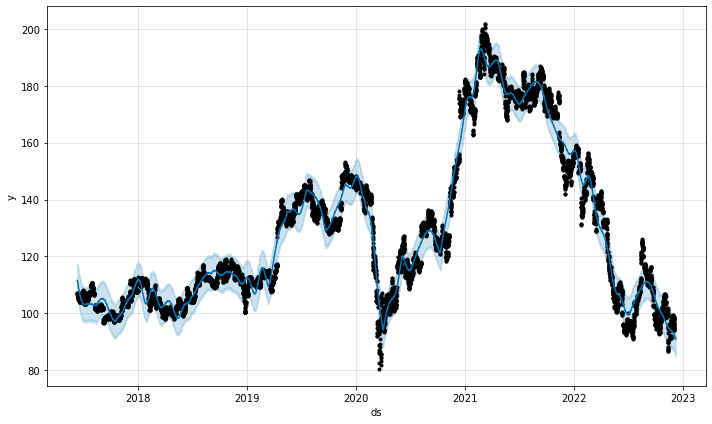

In [21]:
# Python
fig1 = m.plot(forecast)

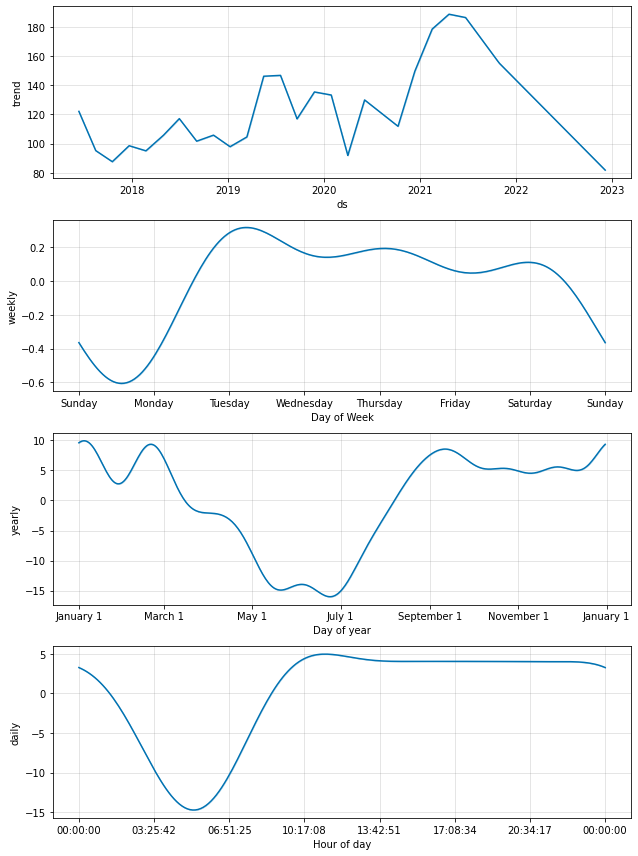

In [22]:
# Python
fig2 = m.plot_components(forecast)

In [23]:
# Python
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [24]:
# Python
plot_components_plotly(m, forecast)